<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Sentiment analysis con Embeddings + LSTM

### Objetivo
El objetivo es utilizar las críticas de compradores de ropa para que el sistema determine la evaluación del comprador y su crítica (cuantas estrellas le asigna al producto).

Ejercicio

- Utilizar Embeddings + LSTM para clasificar críticas de compradores de ropa.

- Deberá balancear el dataset.

- El accuracy de validación deberá rondar entre los 0.5 y 0.7.

- Pruebe con y sin embeddings pre-entrenados.

In [96]:
!pip install --upgrade --no-cache-dir gdown --quiet

In [97]:
import numpy as np
import random
import io
import pickle
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding

### Datos
Utilizaremos como dataset críticas de compradores de ropa (eCommerce) los cuales puntuaron a cada prenda con un puntaje de 1 a 5 estrellas.\
Referencia del dataset: [LINK](https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews/version/1)

In [98]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('clothing_ecommerce_reviews.csv', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1Urn1UFSrodN5BuW6-sc_igtaySGRwhV8'
    output = 'clothing_ecommerce_reviews.csv'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [99]:
# Armar el dataset
df = pd.read_csv('clothing_ecommerce_reviews.csv')
df.drop(columns = ['Unnamed: 0'], inplace = True)
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


### 1 - Limpieza de datos
Alumno:
- Del dataset unicamente utilizar las columnas "Review Text" y "Rating.
- Tranformar el rating 1-5 a una escala numérica de 0 a 4.



In [100]:
df_reviews = df.loc[:, ['Review Text', 'Rating']].dropna()
df_reviews['Rating'] = df_reviews['Rating'] - 1
df_reviews.head()

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comf...,3
1,Love this dress! it's sooo pretty. i happene...,4
2,I had such high hopes for this dress and reall...,2
3,"I love, love, love this jumpsuit. it's fun, fl...",4
4,This shirt is very flattering to all due to th...,4


Distribución de ratings:
Rating
0      821
1     1549
2     2823
3     4908
4    12540
Name: count, dtype: int64


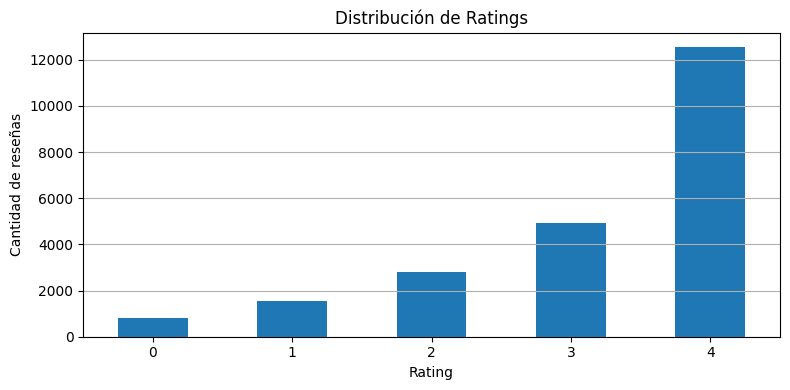

In [101]:
distribucion = df_reviews['Rating'].value_counts().sort_index()
print("Distribución de ratings:")
print(distribucion)
plt.figure(figsize=(8, 4))
distribucion.plot(kind='bar')
plt.xlabel('Rating')
plt.ylabel('Cantidad de reseñas')
plt.title('Distribución de Ratings')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

Se puede observar que tenemos un dataset muy desbalanceado, con una mayor cantidad de datos para la clases de mayor raiting.

In [102]:
# Alumno: tomar la columna de las review y almacenarlo todo en un vector numpy de reviews

In [103]:
reviews = np.array(df_reviews['Review Text'])

In [104]:
# Alumno: Cuantas reviews (rows) hay para evaluar?

In [105]:
print("Cantidad de reviews:", len(reviews))

Cantidad de reviews: 22641


In [106]:
# Alumno: Concatenar todas las reviews para armar el corpus

In [107]:
corpus = ' '.join(reviews)

In [108]:
print(corpus[0:500])

Absolutely wonderful - silky and sexy and comfortable Love this dress!  it's sooo pretty.  i happened to find it in a store, and i'm glad i did bc i never would have ordered it online bc it's petite.  i bought a petite and am 5'8".  i love the length on me- hits just a little below the knee.  would definitely be a true midi on someone who is truly petite. I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found thi


In [109]:
# Alumno: ¿Cuál es la longitud de ese corpus?

In [110]:
print("Longitud del corpus:", len(corpus))

Longitud del corpus: 7011643


In [111]:
# Alumno: Utilizar "text_to_word_sequence" para separar las palabras en tokens
# recordar que text_to_word_sequence automaticamente quita los signos de puntuacion y pasa el texto a lowercase
from tensorflow.keras.preprocessing.text import text_to_word_sequence

In [112]:
# Alumno: Dar un vistazo a los primeros 20 tokens/palabras

In [113]:
tokens = text_to_word_sequence(corpus)
print(tokens[:20])


['absolutely', 'wonderful', 'silky', 'and', 'sexy', 'and', 'comfortable', 'love', 'this', 'dress', "it's", 'sooo', 'pretty', 'i', 'happened', 'to', 'find', 'it', 'in', 'a']


In [114]:
# Alumno: ¿Cuántos tokens/palabras hay?

In [115]:
print("Cantidad de tokens:", len(tokens))

Cantidad de tokens: 1372203


In [116]:
# Alumno: Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# num_words --> the maximum number of words to keep, based on word frequency.
# Only the most common num_words-1 words will be kept.
from tensorflow.keras.preprocessing.text import Tokenizer
num_words = 2000
vocab_size = num_words

In [117]:
tokenizer = Tokenizer(num_words=num_words)

In [118]:
# Alumno: Convertir las palabras/tokens a números

In [119]:
# Ajustar el tokenizador al texto
tokenizer.fit_on_texts(df_reviews['Review Text'])
sequences = tokenizer.texts_to_sequences(df_reviews['Review Text'])
print("Texto original:", df_reviews['Review Text'].iloc[0])
print("Secuencia tokenizada:", sequences[0])

Texto original: Absolutely wonderful - silky and sexy and comfortable
Secuencia tokenizada: [253, 532, 917, 3, 662, 3, 68]


In [120]:
# Alumno: Obtener el diccionario de palabra (word) a índice
# y observar la cantidad total del vocabulario

In [121]:
word_index = tokenizer.word_index
print("Primeras 10 palabras en el diccionario:")
for i, (word, idx) in enumerate(word_index.items()):
    if i == 10:
        break
    print(f"{word}: {idx}")


print(f"\nCantidad total de palabras únicas en el vocabulario: {len(word_index)}")


Primeras 10 palabras en el diccionario:
the: 1
i: 2
and: 3
a: 4
it: 5
is: 6
this: 7
to: 8
in: 9
but: 10

Cantidad total de palabras únicas en el vocabulario: 14847


In [122]:
# Alumno: Determinar cual es la oración más larga

In [123]:
lengths = [len(seq) for seq in sequences]
max_length = max(lengths)
print(f"Longitud máxima de una oración: {max_length}")
# Índice de la oración más larga
idx_max = lengths.index(max_length)

print("\nOración más larga:")
print(df_reviews['Review Text'].iloc[idx_max])


Longitud máxima de una oración: 115

Oración más larga:
I love maeve tops. i love the material and feel of this brand. when i saw the new tops that came out i ran to my local store to try one on. i'm usually a large in a top, once in a while an xl. they only had a large to try so i tried it in the black motif.
i could barely get the top on. it looked like i was missing 1/2 of the top. i doubled checked the size and it was a large.
it's a shame, the top is really cute. if you are the least bit broad or busty, go up a size or two. if you are usually a


Hacer padding sirve para que todas las oraciones tengan la misma cantidad de palabras (tokens), ya que los modelos de deep learning necesitan que las entradas tengan el mismo tamaño. Si una reseña es muy corta, se le agregan ceros al final; si es muy larga, se corta. Esto permite que todas las oraciones puedan procesarse juntas en una matriz numérica de forma consistente.

In [124]:
# Alumno: Realizar padding de las sentencias al mismo tamaño
# tomando de referencia la máxima sentencia
from tensorflow.keras.utils import pad_sequences
maxlen = 115

In [125]:
# Alumno: Observar las dimensiones de la variable input

In [126]:
X = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post')

print("Shape del array con padding:", X.shape)
print("Primera secuencia padded:", X[0])

Shape del array con padding: (22641, 115)
Primera secuencia padded: [253 532 917   3 662   3  68   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0]


In [127]:
# Alumno tomar la columna rating y alcemacenarla en una variable "y" transformada a oneHotEncoding
# Su shape debe ser equivalente la cantidad de rows del corpus y a la cantidad
# de clases que se deseen predecir (en este ejemplo son 5)

In [128]:
y = df_reviews['Rating']
y = to_categorical(y, num_classes=5)

In [129]:
y_labels = np.argmax(y, axis=1)

unique, counts = np.unique(y_labels, return_counts=True)

for cls, count in zip(unique, counts):
    print(f"Clase {cls}: {count} ejemplos")

Clase 0: 821 ejemplos
Clase 1: 1549 ejemplos
Clase 2: 2823 ejemplos
Clase 3: 4908 ejemplos
Clase 4: 12540 ejemplos


Como vimos anteriormente, nuestro dataset está claramente desbalanceado, ya que existen muchas más reseñas con puntaje alto (clase 4) que con puntajes bajos o intermedios. Esto puede hacer que el modelo tienda a predecir mayoritariamente la clase 4, descuidando las opiniones negativas o moderadas. Por ello, antes de continuar, vamos a balancear el dataset aplicando un método que asigne mayor peso a las clases menos representadas durante el entrenamiento (usando class_weight). Esto permitirá que el modelo preste la debida atención a todas las opiniones y mejore su capacidad de generalización.

In [130]:
# Alumno: Dividir los datos en train y test
from sklearn.model_selection import train_test_split

In [131]:
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [132]:
# Alumno: determinar la dimensiones de entrada y salida

In [133]:
X.shape


(22641, 115)

Dimensión de entrada: 115 (longitud máxima de cada secuencia)

In [134]:
y.shape


(22641, 5)

Dimensión de salida: 5 (por la cantidad de clases)

### 2 - Entrenar el modelo con Embeddings + LSTM

- Pruebe con y sin embeddings pre-entrenados.

In [135]:
# Alumno: Entrene su modelo con LSTM entrenando sus propios embeddings
# o utilizando embeddings pre-entrenados.
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout

In [136]:
from tensorflow.keras.layers import LSTM, Embedding, Dropout, Masking, Bidirectional,GlobalMaxPooling1D


In [137]:
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


In [138]:
y_train_labels = np.argmax(y_train, axis=1)
weights = class_weight.compute_class_weight(class_weight='balanced',
                                             classes=np.unique(y_train_labels),
                                             y=y_train_labels)
class_weights = dict(enumerate(weights))

In [139]:
print(class_weights)

{0: np.float64(5.382466567607727), 1: np.float64(2.9212903225806452), 2: np.float64(1.6207606263982104), 3: np.float64(0.9126732174351222), 4: np.float64(0.36242121060530263)}


In [140]:
input_length = x_train.shape[1]     # 115
vocab_size = 2000
output_dim = y.shape[1]             # 5 clases


## Sin embeddings pre entrenados

In [141]:
output_dim = 5
model = Sequential()
model.add(Embedding(input_dim=num_words, output_dim=128, input_length=maxlen, mask_zero=True))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(output_dim, activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


**Breve explicacion de la red**

esta red neuronal diseñada para clasificación de texto en cinco clases. Arranca con una capa de Embedding que transforma cada palabra en un vector denso de 128 dimensiones, utilizando mask_zero=True para que se ignoren correctamente los tokens de padding. Luego, un LSTM bidireccional procesa la secuencia en ambas direcciones, lo que permite capturar tanto el contexto previo como el posterior de cada palabra. La salida secuencial se resume con una capa de GlobalMaxPooling1D, extrayendo las características más relevantes a lo largo del tiempo. A continuación, una capa densa con activación ReLU y Dropout se encarga de aprender representaciones no lineales robustas, antes de llegar a la capa final softmax que asigna la probabilidad de pertenencia a cada una de las cinco clases. En resumen, esta arquitectura busca combinar la captura de contexto y la extracción de características significativas para clasificar eficientemente las críticas.

In [142]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [143]:
history = model.fit(x_train, y_train,
                    validation_data=(x_test, y_test),
                    epochs=10,
                    batch_size=64,
                    class_weight=class_weights)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'global_max_pooling1d_4' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


283/283 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.3065 - loss: 1.5195 - val_accuracy: 0.5951 - val_loss: 1.0314
Epoch 2/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.5246 - loss: 1.2075 - val_accuracy: 0.6019 - val_loss: 0.9508
Epoch 3/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.5774 - loss: 1.0999 - val_accuracy: 0.5427 - val_loss: 1.1143
Epoch 4/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.5966 - loss: 1.0324 - val_accuracy: 0.5648 - val_loss: 0.9757
Epoch 5/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.6192 - loss: 0.9541 - val_accuracy: 0.6072 - val_loss: 0.9342
Epoch 6/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.6335 - loss: 0.8737 - val_accuracy: 0.5467 - val_loss: 1.0113
Epoch 7/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.6337 - loss: 0.8314 - val_accuracy: 0.6041 - val_loss: 0.9931
Epoch 8/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.6659 - loss: 0.7587 - val_accuracy: 0.59

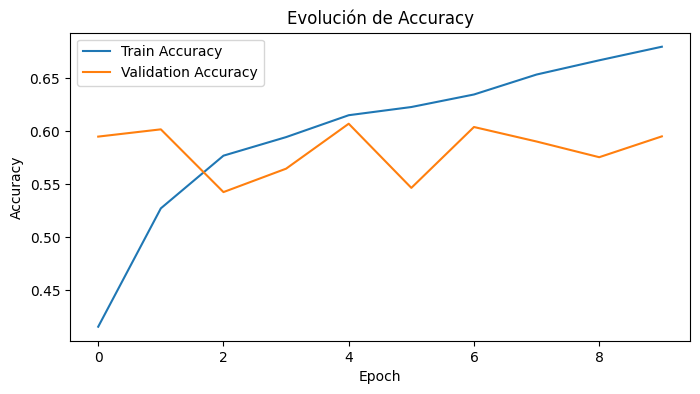

In [144]:
plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Evolución de Accuracy')
plt.legend()
plt.show()

## Con embeddings pre entrenados

In [145]:
embedding_index = {}
with open('glove.6B.100d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector



In [146]:
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector




In [147]:
model2 = Sequential()
model2.add(Embedding(input_dim=vocab_size,
                     output_dim=embedding_dim,
                     weights=[embedding_matrix],
                     trainable=False))

model2.add(Bidirectional(LSTM(128, return_sequences=True)))
model2.add(GlobalMaxPooling1D())
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(output_dim, activation='softmax'))



In [148]:
model2.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [149]:
history_pre_trained = model2.fit(x_train, y_train,
                    validation_data=(x_test, y_test),
                    epochs=10,
                    batch_size=64,
                    class_weight=class_weights)

Epoch 1/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2817 - loss: 1.6115 - val_accuracy: 0.5123 - val_loss: 1.2050
Epoch 2/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.4837 - loss: 1.3313 - val_accuracy: 0.5575 - val_loss: 1.0263
Epoch 3/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.5227 - loss: 1.2436 - val_accuracy: 0.5138 - val_loss: 1.1299
Epoch 4/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.5441 - loss: 1.1818 - val_accuracy: 0.5703 - val_loss: 1.0351
Epoch 5/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.5711 - loss: 1.0887 - val_accuracy: 0.5811 - val_loss: 0.9351
Epoch 6/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.5838 - loss: 1.0507 - val_accuracy: 0.5681 - val_loss: 1.0447
Epoch 7/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.6116 - loss: 0.9626 - val_accuracy: 0.6308 - val_loss: 0.8919
Epoch 8/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.6134 - loss: 0.9283 - val_acc

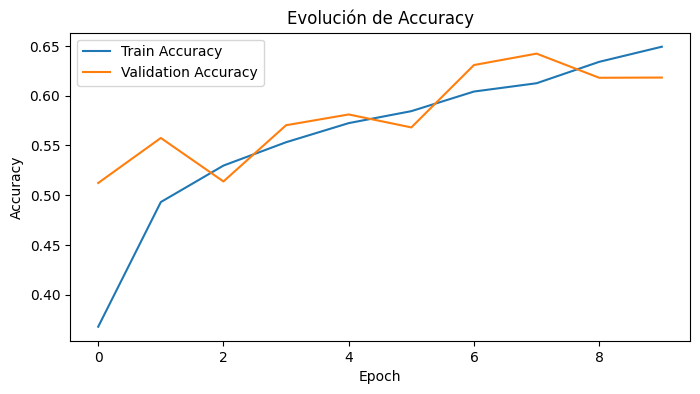

In [150]:
plt.figure(figsize=(8,4))
plt.plot(history_pre_trained.history['accuracy'], label='Train Accuracy')
plt.plot(history_pre_trained.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Evolución de Accuracy')
plt.legend()
plt.show()

## Comparacion entre pre-embedding y no

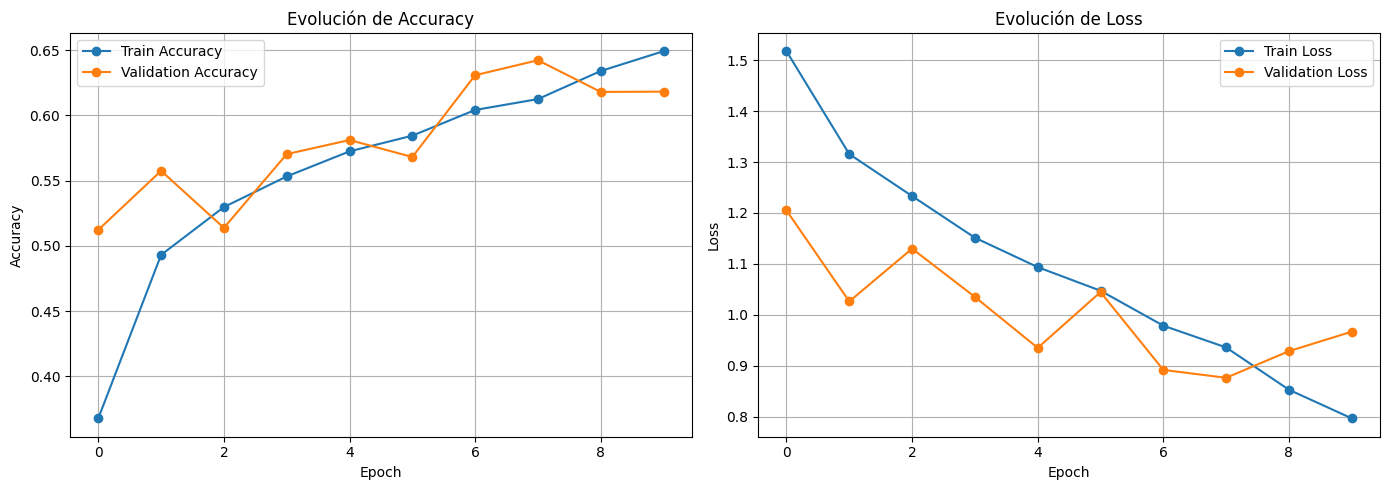

In [151]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(history_pre_trained.history['accuracy'], marker='o', label='Train Accuracy')
ax1.plot(history_pre_trained.history['val_accuracy'], marker='o', label='Validation Accuracy')
ax1.set_title('Evolución de Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.grid(True)
ax1.legend()


ax2.plot(history_pre_trained.history['loss'], marker='o', label='Train Loss')
ax2.plot(history_pre_trained.history['val_loss'], marker='o', label='Validation Loss')
ax2.set_title('Evolución de Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()


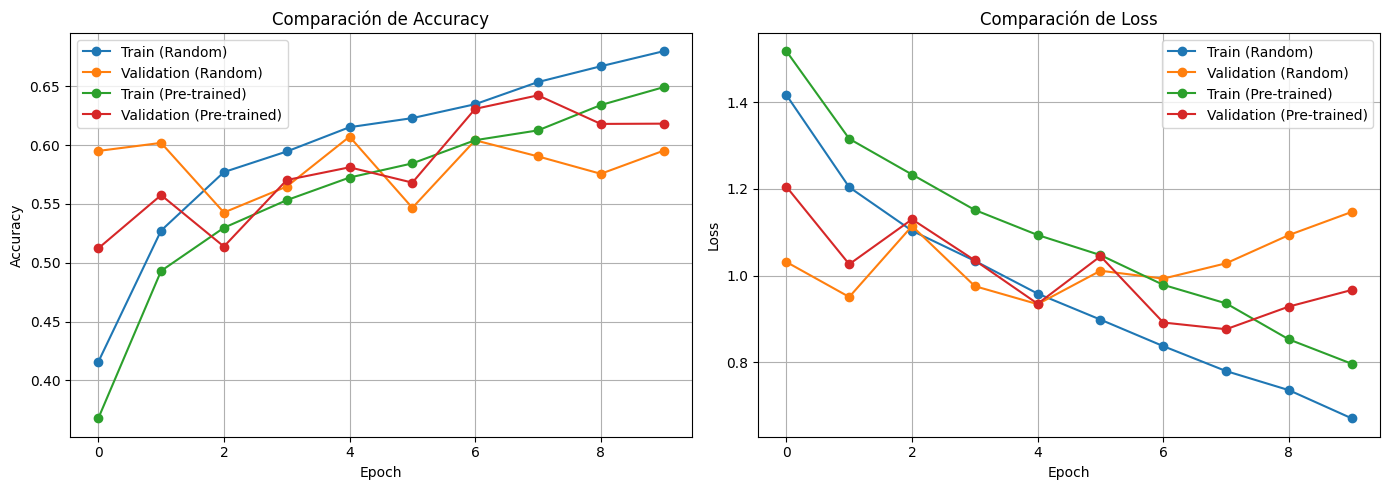

In [152]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Comparación de Accuracy
ax1.plot(history.history['accuracy'], marker='o', label='Train (Random)')
ax1.plot(history.history['val_accuracy'], marker='o', label='Validation (Random)')
ax1.plot(history_pre_trained.history['accuracy'], marker='o', label='Train (Pre-trained)')
ax1.plot(history_pre_trained.history['val_accuracy'], marker='o', label='Validation (Pre-trained)')
ax1.set_title('Comparación de Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.grid(True)
ax1.legend()

# Comparación de Loss
ax2.plot(history.history['loss'], marker='o', label='Train (Random)')
ax2.plot(history.history['val_loss'], marker='o', label='Validation (Random)')
ax2.plot(history_pre_trained.history['loss'], marker='o', label='Train (Pre-trained)')
ax2.plot(history_pre_trained.history['val_loss'], marker='o', label='Validation (Pre-trained)')
ax2.set_title('Comparación de Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()


En el modelo sin pre-embeddings se alcanza una accuracy de entrenamiento de 69.09% con una loss de 0.6550, pero la performance en validación es menor (accuracy de 59.53% y loss de 1.1469). En contraste, el modelo con embeddings pre-entrenados muestra una accuracy de entrenamiento un poco más baja (65.81%) y una loss más alta (0.7863), pero mejora en validación, alcanzando 61.82% de accuracy y una loss de 0.9669. Esto sugiere que, aunque el modelo sin pre-entrenamiento se ajusta mejor a los datos de entrenamiento, el uso de embeddings pre-entrenados ayuda a generalizar mejor, probablemente al capturar características semánticas más robustas y reducir el sobreajuste. En resumen, para nuestro caso, el modelo con embeddings pre-entrenados ofrece un desempeño más equilibrado en datos no vistos, lo cual es fundamental en aplicaciones reales.